# Fase 6: Evualación del Sistema

#### **Objetivo:**

El objetivo de esta fase es evaluar la eficacia del sistema de recuperación de información mediante el cálculo de métricas de rendimiento como precisión y recall. Además, se utiliza una matriz de confusión para visualizar el rendimiento del modelo en términos de verdaderos positivos, falsos positivos y falsos negativos.

#### **Descripción:**

En esta fase, se mide el rendimiento del sistema de búsqueda utilizando consultas predefinidas y comparando los resultados obtenidos con un conjunto de documentos relevantes conocidos. Se calculan métricas como precisión y recall para determinar cuán eficazmente el sistema recupera documentos relevantes y evita los irrelevantes. La matriz de confusión proporciona una representación visual del rendimiento del modelo, ayudando a identificar áreas de mejora.

#### **Pasos para calcular las métricas:**

1. **Lectura de Consultas:**
    - Se leen las consultas desde un archivo que contiene las consultas y los documentos relevantes esperados para cada una.

2. **Cálculo de Precisión y Recall:**
    - **Precisión:** 
      - Se calcula la precisión como la proporción de documentos relevantes recuperados sobre el total de documentos recuperados.
    - **Recall:** 
      - Se calcula el recall como la proporción de documentos relevantes recuperados sobre el total de documentos relevantes esperados.

3. **Evaluación del Modelo:**
    - Se realizan búsquedas utilizando el sistema desarrollado y se comparan los resultados obtenidos con los documentos relevantes esperados.
    - Se calculan y promedian las métricas de precisión y recall para todas las consultas evaluadas.

4. **Matriz de Confusión:**
    - Se construye una matriz de confusión que visualiza el rendimiento del modelo en términos de verdaderos positivos (TP), falsos positivos (FP) y falsos negativos (FN).
    - La matriz de confusión se utiliza para identificar patrones de error y evaluar la capacidad del modelo para distinguir entre documentos relevantes e irrelevantes.

5. **Visualización de Resultados:**
    - Se grafican los resultados utilizando una matriz de confusión para proporcionar una representación clara y visual del rendimiento del sistema.

Al completar esta fase, se obtienen métricas cuantitativas que permiten evaluar la eficacia del sistema de recuperación de información y guiar las mejoras futuras en su desarrollo.


In [1]:
import os
import re
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
# Download the 'punkt' resource
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def separar_indice(filepath):
    try:
        print(f"Cargando índice invertido desde: {filepath}")
        inverted_index = {}
        with open(filepath, 'r', encoding='utf-8') as file:
            current_term = None
            for line in file:
                line = line.strip()
                if line.startswith("Termino:"):
                    current_term = line.split("Termino: ")[1]
                    inverted_index[current_term] = []
                elif line.startswith("Documento:"):
                    doc_info = line.split("Documento: ")[1]
                    doc_name, weight = doc_info.split(", Frecuencia: ")
                    inverted_index[current_term].append((doc_name, float(weight)))
        return inverted_index
    except FileNotFoundError:
        print(f"Error: Archivo no encontrado en {filepath}")
        raise
    except Exception as e:
        print(f"Error al cargar el índice invertido desde {filepath}: {str(e)}")
        raise

In [3]:
# Función para cargar stopwords desde un archivo
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
         stopwords = set(word.strip() for word in file.readlines())
    return set(stopwords)

In [4]:
# Función para preprocesar el texto
def preprocess_text(text, stopwords):
    # Convertir el texto a minúsculas
    text = text.lower()

    # Remover caracteres no alfabéticos y números
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenizar el texto en palabras
    tokens = word_tokenize(text)

    # Inicializar el stemmer
    stemmer = SnowballStemmer('english')

    # Aplicar stemming
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Eliminar stopwords después del stemming
    cleaned_tokens = [token for token in stemmed_tokens if token not in stopwords]

    # Unir los tokens limpios en una cadena de texto
    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

# Ruta del archivo de stopwords
stopwords_file = 'Proyecto_Data/reuters/stopwords.txt'

# Cargar stopwords
stopwords = load_stopwords(stopwords_file)

# Directorio donde se encuentran los archivos
CORPUS_DIR = 'Proyecto_Data/reuters/training'

# Diccionario para almacenar los textos procesados de todos los archivos
diccionario = {}

# Procesar cada archivo en el directorio
for filename in os.listdir(CORPUS_DIR):
    filepath = os.path.join(CORPUS_DIR, filename)
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as file:
        text = file.read()
        cleaned_text = preprocess_text(text, stopwords) 
        diccionario[filename] = cleaned_text

In [5]:
def prepocesar_query(query):
    query_prepocesada = preprocess_text(query, stopwords) 
    print(f"Consulta procesada: {query_prepocesada}")
    return query_prepocesada.split()

In [6]:
import math

def coseno_similaridad(query_vector, doc_vector):
    dot_product = sum(query_vector[term] * doc_vector.get(term, 0) for term in query_vector)
    query_norm = math.sqrt(sum(weight ** 2 for weight in query_vector.values()))
    doc_norm = math.sqrt(sum(weight ** 2 for weight in doc_vector.values()))
    if query_norm == 0 or doc_norm == 0:
        return 0
    return dot_product / (query_norm * doc_norm)

In [7]:
def jaccard_similaridad(query_tokens, document_tokens):
    intersection = len(set(query_tokens) & set(document_tokens))
    union = len(set(query_tokens) | set(document_tokens))
    return intersection / union if union != 0 else 0

In [8]:
from collections import defaultdict

def busqueda_coseno(query, inverted_index):
    try:
        query_tokens = prepocesar_query(query)
        query_vector = {term: query_tokens.count(term) for term in query_tokens}
        document_vectors = defaultdict(dict)
        for term in query_tokens:
            if term in inverted_index:
                for doc_id, tfidf_score in inverted_index[term]:
                    document_vectors[doc_id][term] = tfidf_score
        scores = {}
        for doc_id in document_vectors:
            scores[doc_id] = coseno_similaridad(query_vector, document_vectors[doc_id])
        ranked_results = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        doc_ids = [doc_id for doc_id, _ in ranked_results]
        return doc_ids
    except Exception as e:
        print(f"Error in search_cosine: {str(e)}")
        raise

In [31]:
def busqueda_jaccard(query, inverted_index):
    try:
        CORPUS_DIR = os.path.join(os.getcwd(), 'Proyecto_Data', 'reuters', 'training')
        documents = {}
        for filename in os.listdir(CORPUS_DIR):
            if filename.endswith(".txt"):
                filepath = os.path.join(CORPUS_DIR, filename)
                with open(filepath, 'r', encoding='utf-8') as file:
                    text = file.read()
                    cleaned_text = preprocess_text(text, stopwords) 
                    documents[filename] = cleaned_text
        query_tokens = prepocesar_query(query)
        
        # Utiliza el índice invertido para obtener los documentos relevantes
        relevant_docs = set()
        for token in query_tokens:
            if token in inverted_index:
                relevant_docs.update([doc_info[0] for doc_info in inverted_index[token]])
        
        document_tokens = {doc_id: documents[doc_id].split() for doc_id in relevant_docs}
        results = []
        for doc_id in document_tokens:
            similarity = jaccard_similaridad(query_tokens, document_tokens[doc_id])
            results.append((doc_id, similarity))
        ranked_results = sorted(results, key=lambda x: x[1], reverse=True)
        doc_ids = [doc_id for doc_id, _ in ranked_results]
        return doc_ids
    except Exception as e:
        print(f"Error in search_jaccard: {str(e)}")
        raise


In [32]:
# Cargar índice según el tipo de vector (TF-IDF o Bag of Words)
def load_index(tv):
    if tv == "0":
        filepath = os.path.join(os.getcwd(), 'Proyecto_Data', 'results', 'indice_tf_idf.txt')
    elif tv == "1":
        filepath = os.path.join(os.getcwd(), 'Proyecto_Data', 'results', 'indice_bow.txt')
    else:
        raise ValueError("El tipo de vector debe ser '0' para TF-IDF o '1' para Bag of Words.")

    return separar_indice(filepath)

In [33]:
# Función principal de búsqueda
def results(query, tv, tr):
    inverted_index_loaded = load_index(tv)
    if tv == "0":
        return busqueda_coseno(query, inverted_index_loaded)
    elif tv == "1":
        return busqueda_jaccard(query, inverted_index_loaded)
    else:
        raise ValueError("El tipo de vector debe ser '0' para usar búsqueda coseno o '1' para usar búsqueda Jaccard.")

# Metricas

In [12]:
def read_queries_from_file(file_path):
    queries = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(': ')
            if len(parts) == 2:
                query_name = parts[0]
                numbers = list(map(int, re.findall(r'\d+', parts[1])))  # Convertir a lista en lugar de conjunto
                queries.append((query_name, numbers))
    return queries

In [13]:
def calculo_recall(predichos, gt):
    predichos = set(int(doc.split('.')[0]) for doc in predichos)
    TP = len(predichos.intersection(gt))
    FP = len(predichos.difference(gt))
    total = TP + FP
    
    if total == 0:
        return 0.0  # Evita división por cero
    
    recall = TP / total
    return recall * 100

In [14]:
def calculo_precision(predichos, gt):
    predichos = set(int(doc.split('.')[0]) for doc in predichos)
    gt = set(gt)  # Convertir gt a conjunto
    TP = len(predichos.intersection(gt))
    FN = len(gt.difference(predichos))
    total = TP + FN
    
    if total == 0:
        return 0.0  # Evita división por cero
    
    precision = TP / total
    return precision * 100


# TF-IDF

In [15]:
file_path = 'indice_inverido.txt'
queries = read_queries_from_file(file_path)

total_recall = 0
total_precision = 0
total_queries = len(queries)

for query_name, numbers_set in queries:
    query = query_name  # Assuming query_name holds the query
    query_results = results(query, "0", "1")  # Call the function with the query
    print("====================================================================")
    print("Resultados para: ", query_name)
    print("Documentos recuperados: ", query_results)
    print("Cantidad de predicciones: ", len(query_results))
    print("Números esperados: ", numbers_set)
    recall = calculo_recall(query_results, numbers_set)
    precision = calculo_precision(query_results, numbers_set)
    total_recall += recall
    total_precision += precision
    print("Recall: ", recall)
    print("Precision: ", precision)

Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_tf_idf.txt
Consulta procesada: cocoa
Resultados para:  cocoa
Documentos recuperados:  ['1.txt', '10014.txt', '10122.txt', '10403.txt', '10449.txt', '10471.txt', '10491.txt', '10505.txt', '10506.txt', '10584.txt', '10586.txt', '10613.txt', '10619.txt', '10742.txt', '10760.txt', '11224.txt', '11341.txt', '11459.txt', '11462.txt', '11811.txt', '11843.txt', '12340.txt', '12355.txt', '12763.txt', '12813.txt', '13271.txt', '13462.txt', '14418.txt', '1889.txt', '2521.txt', '275.txt', '3190.txt', '3225.txt', '3310.txt', '4147.txt', '4470.txt', '4564.txt', '5168.txt', '5192.txt', '5258.txt', '5382.txt', '5491.txt', '5598.txt', '5880.txt', '6128.txt', '6407.txt', '6414.txt', '6493.txt', '7071.txt', '7311.txt', '7367.txt', '8326.txt', '8850.txt', '8961.txt', '8978.txt', '9450.txt', '9559.txt', '9903.txt', '9953.txt']
Cantidad de predicciones:  59
Númer

In [16]:
# Imprimir total de precisión y recall

print("Total de precisión: ", total_precision / total_queries)
print("Total de recall: ", total_recall / total_queries)

Total de precisión:  47.61867281941195
Total de recall:  33.8086807194287


In [17]:
!pip install seaborn

Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_tf_idf.txt
Consulta procesada: cocoa
Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_tf_idf.txt
Consulta procesada: sorghum
Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_tf_idf.txt
Consulta procesada: oat
Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_tf_idf.txt
Consulta procesada: barley
Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_tf_idf.txt
Consulta procesada: corn
Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\

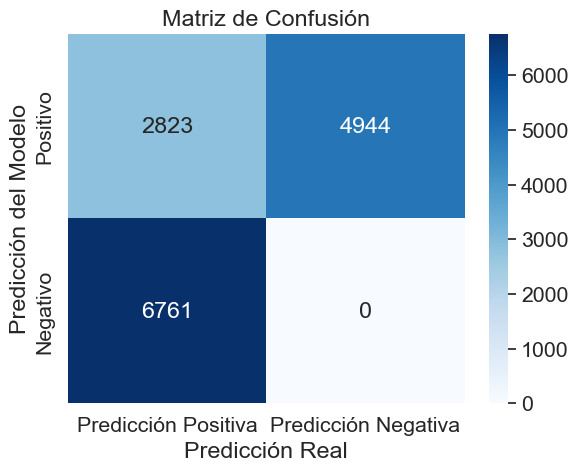

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calcular_matriz_confusion(queries):
    TP_total = 0
    FP_total = 0
    FN_total = 0

    for query_name, numbers_set in queries:
        query_results = results(query_name, "0", "1")
        predichos = set(int(doc.split('.')[0]) for doc in query_results)
        gt = set(numbers_set)

        TP = len(predichos.intersection(gt))
        FP = len(predichos.difference(gt))
        FN = len(gt.difference(predichos))

        TP_total += TP
        FP_total += FP
        FN_total += FN

    matriz_confusion = np.array([[TP_total, FP_total], [FN_total, 0]])  # No hay TN, así que lo dejamos como 0

    return matriz_confusion

def plot_confusion_matrix(matriz_confusion):
    sns.set(font_scale=1.4)  # Ajusta el tamaño de fuente
    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicción Positiva', 'Predicción Negativa'], 
                yticklabels=['Positivo', 'Negativo'])
    plt.xlabel('Predicción Real')
    plt.ylabel('Predicción del Modelo')
    plt.title('Matriz de Confusión')
    plt.show()

# Calcular la matriz de confusión
matriz_confusion = calcular_matriz_confusion(queries)

# Graficar la matriz de confusión
plot_confusion_matrix(matriz_confusion)


In [19]:
# Contar cuantos documentos hay en training

# Directorio donde se encuentran los archivos
directory = 'Proyecto_Data/reuters/training'

# Obtener una lista de todos los archivos en el directorio
files = os.listdir(directory)

# Contar el número de archivos
num_documents = len(files)

# Imprimir el número de documentos
print(num_documents)

7769


# BoW

In [34]:
file_path = 'indice_inverido.txt'
queries = read_queries_from_file(file_path)

total_recall = 0
total_precision = 0
total_queries = len(queries)

for query_name, numbers_set in queries:
    query = query_name  # Assuming query_name holds the query
    query_results = results(query, "1", "1")  # Call the function with the query
    print("====================================================================")
    print("Resultados para: ", query_name)
    print("Documentos recuperados: ", query_results)
    print("Cantidad de predicciones: ", len(query_results))
    print("Números esperados: ", numbers_set)
    recall = calculo_recall(query_results, numbers_set)
    precision = calculo_precision(query_results, numbers_set)
    total_recall += recall
    total_precision += precision
    print("Recall: ", recall)
    print("Precision: ", precision)

Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_bow.txt
Consulta procesada: cocoa
Resultados para:  cocoa
Documentos recuperados:  ['8326.txt', '10491.txt', '10471.txt', '3190.txt', '11811.txt', '12813.txt', '8850.txt', '3225.txt', '10506.txt', '10613.txt', '10619.txt', '8978.txt', '9903.txt', '14418.txt', '5880.txt', '5491.txt', '7367.txt', '10449.txt', '10742.txt', '11462.txt', '6414.txt', '10586.txt', '3310.txt', '11341.txt', '10014.txt', '7311.txt', '10584.txt', '6407.txt', '9450.txt', '4147.txt', '13271.txt', '275.txt', '12763.txt', '6128.txt', '5598.txt', '10505.txt', '9559.txt', '10122.txt', '5382.txt', '5168.txt', '5192.txt', '6493.txt', '9953.txt', '11843.txt', '11459.txt', '10403.txt', '12340.txt', '1.txt', '7071.txt', '8961.txt', '1889.txt', '12355.txt', '4470.txt', '4564.txt', '13462.txt', '10760.txt', '5258.txt', '2521.txt', '11224.txt']
Cantidad de predicciones:  59
Números 

In [35]:
# Imprimir total de precisión y recall

print("Total de precisión: ", total_precision / total_queries)
print("Total de recall: ", total_recall / total_queries)

Total de precisión:  47.61867281941195
Total de recall:  33.8086807194287


Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_bow.txt
Consulta procesada: cocoa
Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_bow.txt
Consulta procesada: sorghum
Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_bow.txt
Consulta procesada: oat
Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_bow.txt
Consulta procesada: barley
Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación Info\Proyecto 2.0\Cambio\Proyecto_Data\results\indice_bow.txt
Consulta procesada: corn
Cargando índice invertido desde: C:\Users\User\Documents\Universidad\7 semestre\Recuperación In

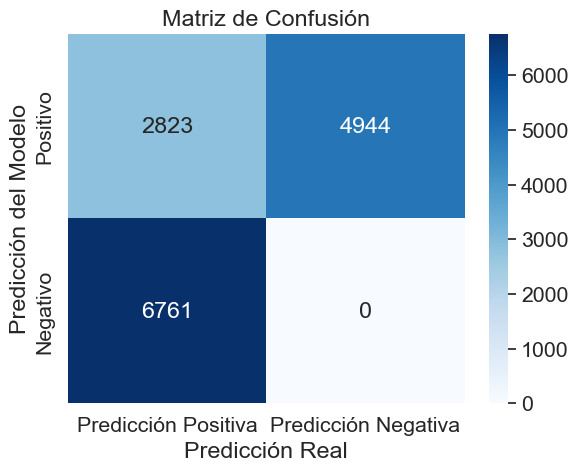

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calcular_matriz_confusion(queries):
    TP_total = 0
    FP_total = 0
    FN_total = 0

    for query_name, numbers_set in queries:
        query_results = results(query_name, "1", "1")
        predichos = set(int(doc.split('.')[0]) for doc in query_results)
        gt = set(numbers_set)

        TP = len(predichos.intersection(gt))
        FP = len(predichos.difference(gt))
        FN = len(gt.difference(predichos))

        TP_total += TP
        FP_total += FP
        FN_total += FN

    matriz_confusion = np.array([[TP_total, FP_total], [FN_total, 0]])  # No hay TN, así que lo dejamos como 0

    return matriz_confusion

def plot_confusion_matrix(matriz_confusion):
    sns.set(font_scale=1.4)  # Ajusta el tamaño de fuente
    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicción Positiva', 'Predicción Negativa'], 
                yticklabels=['Positivo', 'Negativo'])
    plt.xlabel('Predicción Real')
    plt.ylabel('Predicción del Modelo')
    plt.title('Matriz de Confusión')
    plt.show()

# Calcular la matriz de confusión
matriz_confusion = calcular_matriz_confusion(queries)

# Graficar la matriz de confusión
plot_confusion_matrix(matriz_confusion)